In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import numpy as np
import gym as gym
from gym import logger as gymlogger
gymlogger.set_level(40) #error only
from collections import namedtuple, deque
import matplotlib
import matplotlib.pyplot as plt
import time
import cv2 as cv2
import random
import tensorflow.contrib.eager as tfe
import tensorflow as tf
tf.enable_eager_execution()
%matplotlib inline

from utils.plotting import RewardHistory


/home/william/anaconda3/envs/deeprlbootcamp/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Policy Gradient with a model

In [2]:
# import tensorflow.contrib.eager as tfe

class LinearModel(tf.keras.Model):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=2, activation=tf.nn.softmax)

    def call(self, input):
        result = self.dense1(input)
        return result
    
    
    def loss(self, inputs, targets):
        y = self(inputs)
        loss = y * tf.cast(targets, dtype="float32")
        loss = tf.reduce_sum(loss, reduction_indices=1)
#         print(loss.shape)
        loss = tf.log(loss)
        return loss

    def grad(self, inputs, targets, reward):
        with tfe.GradientTape() as tape:
            loss_value = - tf.reduce_mean(self.loss(inputs, targets) * reward)
        return tape.gradient(loss_value, self.variables)
    
    def train(self, optimizer, inputs, targets, reward):
        grads = self.grad(inputs, targets, reward)
        optimizer.apply_gradients(zip(grads, self.variables),
                          global_step=tf.train.get_or_create_global_step())
    
model = LinearModel()

batch = tf.random_uniform([3, 4])
print("batch:", batch)

reward = tf.constant([5., 5., 5.])
reward = tf.expand_dims(reward, axis=1)
print("reward:", reward)

result = model(batch)
print("result:", result)

optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

num_epochs = 5

for epoch in range(num_epochs):

#     y = tf.constant([[0], [1]], dtype="int32")
    y = tf.one_hot([0, 1, 1], depth=2, dtype="int32")
#     y = tf.constant([1, 0, 1], dtype="int32")

    # Optimize the model
    grads = model.grad(batch, y, reward)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step=tf.train.get_or_create_global_step())
        
model(batch)

batch: tf.Tensor(
[[0.1200614  0.5072874  0.8035834  0.6543182 ]
 [0.6132152  0.26021087 0.63011026 0.10300839]
 [0.04349005 0.54816675 0.6988107  0.21357834]], shape=(3, 4), dtype=float32)
reward: tf.Tensor(
[[5.]
 [5.]
 [5.]], shape=(3, 1), dtype=float32)
result: tf.Tensor(
[[0.47400573 0.5259943 ]
 [0.36840683 0.63159317]
 [0.47008684 0.52991307]], shape=(3, 2), dtype=float32)


<tf.Tensor: id=449, shape=(3, 2), dtype=float32, numpy=
array([[0.4315049 , 0.5684951 ],
       [0.31553724, 0.6844628 ],
       [0.42022517, 0.57977486]], dtype=float32)>

In [55]:
# import tensorflow.contrib.eager as tfe

class ValueModel(tf.keras.Model):
    def __init__(self):
        super(ValueModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=32, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=1)

    def call(self, inputs):
        result = self.dense1(inputs)
        result = self.dense2(result)
#         result = self.dense2(inputs)
        return result
    
    
    def loss(self, inputs, targets):
        y = self(inputs)
        loss = tf.losses.mean_squared_error(targets, y)
        return loss

    def grad(self, inputs, targets):
        with tfe.GradientTape() as tape:
            loss_value = tf.reduce_mean(self.loss(inputs, targets))
        return tape.gradient(loss_value, self.variables)
    
    def train(self, optimizer, inputs, targets):
        grads = self.grad(inputs, targets)
        optimizer.apply_gradients(zip(grads, self.variables),
                          global_step=tf.train.get_or_create_global_step())
    

model = ValueModel()

batch = tf.random_uniform([3, 4])
print("batch:", batch)

result = model(batch)
print("result:", result)

optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

num_epochs = 5

for epoch in range(num_epochs):

    y = tf.expand_dims(tf.constant([5, 5, 5], dtype="int32"), axis=1)

    # Optimize the model
    model.train(optimizer, batch, y)
    
        
model(batch)

batch: tf.Tensor(
[[0.5109527  0.67437243 0.07565129 0.83051825]
 [0.56682515 0.09305835 0.17109334 0.8088187 ]
 [0.3299663  0.8917904  0.73388386 0.58941436]], shape=(3, 4), dtype=float32)
result: tf.Tensor(
[[0.14664468]
 [0.04131112]
 [0.08410746]], shape=(3, 1), dtype=float32)


<tf.Tensor: id=99885107, shape=(3, 1), dtype=float32, numpy=
array([[1.1399497],
       [0.9152825],
       [1.1756341]], dtype=float32)>

# Ok, now we do Policy Gradient

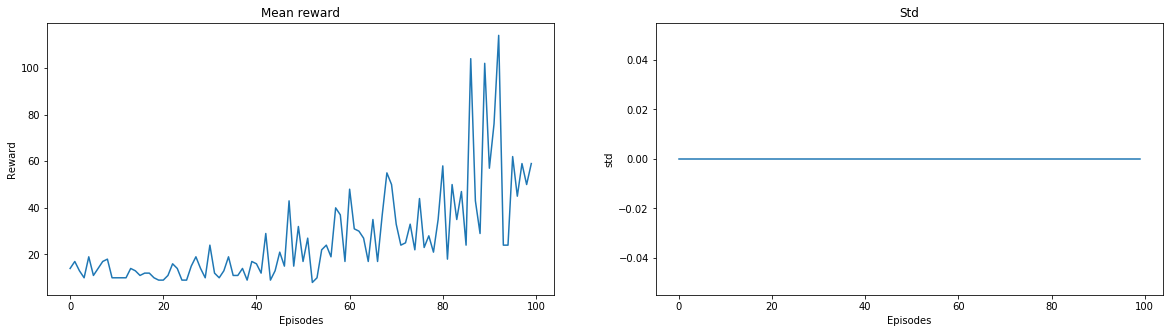

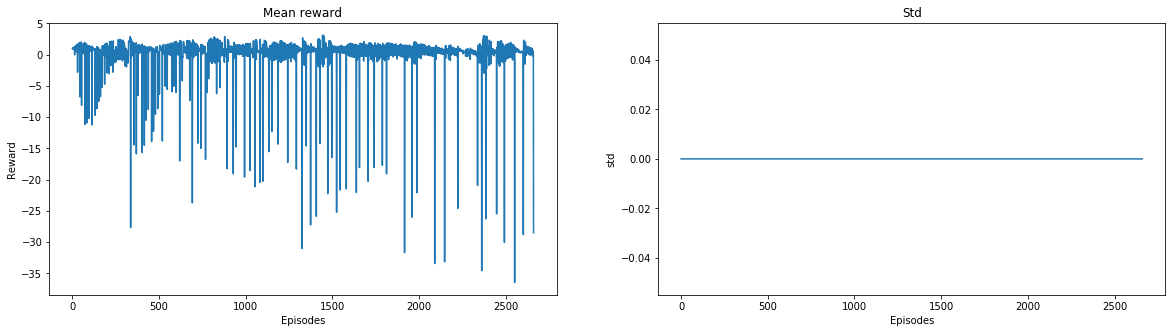

In [56]:
class Agent():
    def __init__(self):
        self.env = gym.make('CartPole-v0')
        self.episode_durations = []
        self.episode_loss = []
        self.gamma = 0.99
        self.model = LinearModel()
        self.value_model = ValueModel()
#         self.memory = PolicyGradientMemory()
        self.action_optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
        self.value_optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
        
    def getAction(self, s):
        s = tf.convert_to_tensor([s])
        action_probability = self.model(s).numpy()
#         print(action_probability)
        action = np.random.choice([0, 1], p=action_probability[0])
        return action
    
    def train(self, episodes=2):
        all_returns = [[] for _ in range(200)]
        for i in range(episodes):
            s = self.env.reset()
            steps = 0
            while True:
                action = self.getAction(s)
                
                s_1, reward, done, info = self.env.step(action)
#                 self.memory.append(Transition(s, action, reward))
                
                s0 = tf.constant([s])
                s1 = tf.constant([s_1])
                r = tf.constant([reward])
                a = tf.one_hot([action], depth=2, dtype="int32")
                d = tf.constant([1 - done], dtype=tf.float32)
                
                v = self.value_model(s0)
                v_prime = self.value_model(s1)
                y = r + self.gamma * d * v_prime
                td_loss = y - v
#                 print(tf.reduce_max(td_loss).numpy())
                self.episode_loss.append(tf.reduce_max(td_loss).numpy())
                self.value_model.train(self.value_optimizer, s0, y)
                self.model.train(self.action_optimizer, s0, a, td_loss)
    
                s = s_1
                
                steps += 1
                if done:
                    break

            self.episode_durations.append(steps)
    
    def run(self):
        self.env = gym.make('CartPole-v0')
        s = self.env.reset()
        steps = 0
        while True:
            self.env.render()
            action = self.getAction(s)
            s_1, reward, done, info = self.env.step(action)
            s = s_1
            steps += 1
            if done:
                print("Episode finished successfully after {} timesteps".format(steps))
                break
        self.env.close()

agent = Agent()

reward_history = RewardHistory()
loss_history = RewardHistory()
for i in range(10):
    agent = Agent()
    agent.train(100)
    reward_history.append(agent.episode_durations)
    loss_history.append(agent.episode_loss)

reward_history.plot()
loss_history.plot()

In [ ]:
###### learner.train(100, show_chart)
for i in range(2):
    agent.run()


# Lessons Learnt


- This is sensitive to the learning rate of both actor and critic

# Mean reward over 100 training sessions

- Actor Critic without a baseline
![mean reward](./images/actor_critic.png)

# Combined model

In [ ]:
# import tensorflow.contrib.eager as tfe

class CombinedModel(tf.keras.Model):
    def __init__(self):
        super(ValueModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=1)

    def call(self, input):
        result = self.dense1(input)
        result = self.dense2(result)
        return result
    
    
    def v_loss(self, inputs, targets):
        y = self(inputs)
        loss = tf.losses.mean_squared_error(targets, y)
        return loss

    def v_grad(self, inputs, targets):
        with tfe.GradientTape() as tape:
            loss_value = tf.reduce_mean(self.loss(inputs, targets))
        return tape.gradient(loss_value, self.variables)
    
    def v_train(self, optimizer, inputs, targets):
        grads = self.grad(inputs, targets)
        optimizer.apply_gradients(zip(grads, self.variables),
                          global_step=tf.train.get_or_create_global_step())
    

model = ValueModel()

batch = tf.random_uniform([3, 4])
print("batch:", batch)

result = model(batch)
print("result:", result)

optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

num_epochs = 5

for epoch in range(num_epochs):

    y = tf.expand_dims(tf.constant([5, 5, 5], dtype="int32"), axis=1)

    # Optimize the model
    model.train(optimizer, batch, y)
    
        
model(batch)